In [1]:
import os
import sys 
sys.path.append(os.path.abspath('..'))
import json
from pathlib import Path
from utils import create_directory
from model import test
import plot as plot
import numpy as np
import matplotlib.pyplot as plt
from utils import optimize_channel

In [34]:
model_num = 11
model_name = "model{:02d}".format(model_num)
data_dir = create_directory(directory_name='finetune7')

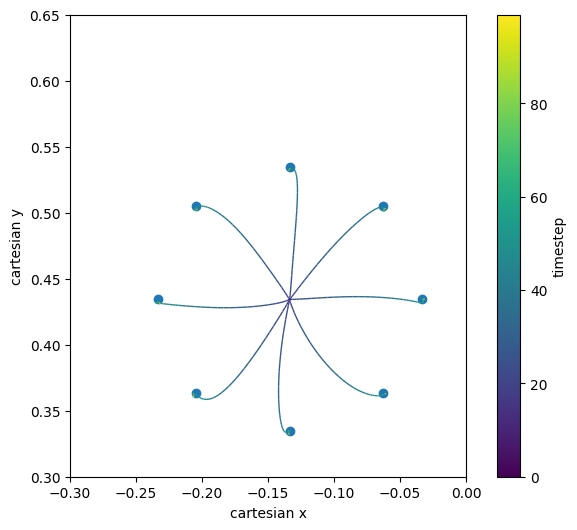

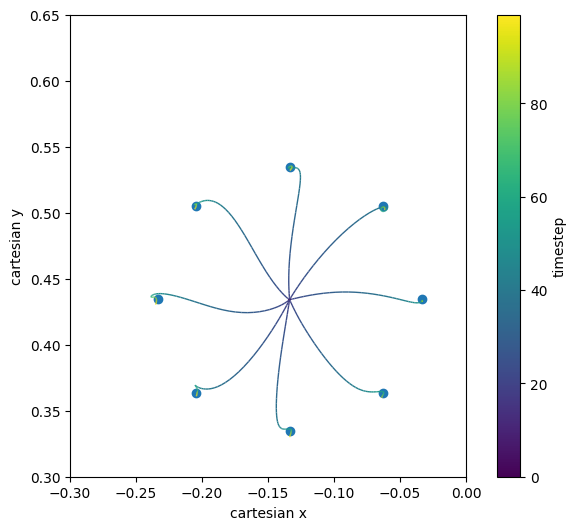

In [37]:
phase = 'NF1'
ff_coefficient = 0

weight_file = list(Path(data_dir).glob(f'{model_name}_phase={phase}_*_weights'))[0]
cfg_file = list(Path(data_dir).glob(f'{model_name}_phase={phase}_*_cfg.json'))[0]

data = test(cfg_file,weight_file,ff_coefficient=ff_coefficient,is_channel=False)
fig, ax  = plot.plot_simulations(xy=data['xy'],target_xy=data['tg'],vel=None,plot_lat=False)

phase = 'FF1'
ff_coefficient = 8

weight_file = list(Path(data_dir).glob(f'{model_name}_phase={phase}_*_weights'))[0]
cfg_file = list(Path(data_dir).glob(f'{model_name}_phase={phase}_*_cfg.json'))[0]

data = test(cfg_file,weight_file,ff_coefficient=ff_coefficient,is_channel=False)
fig, ax  = plot.plot_simulations(xy=data['xy'],target_xy=data['tg'],vel=None,plot_lat=False)

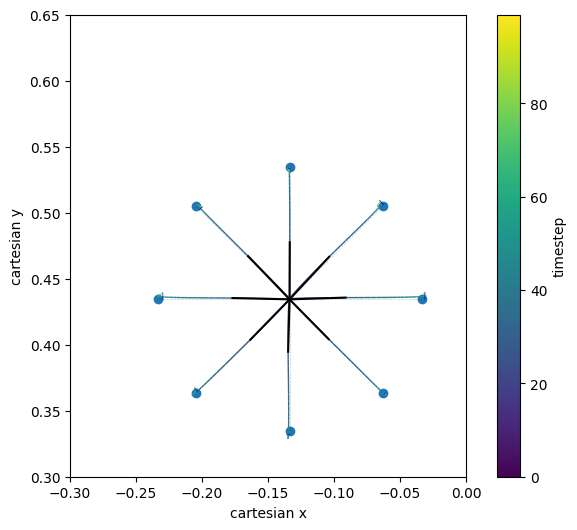

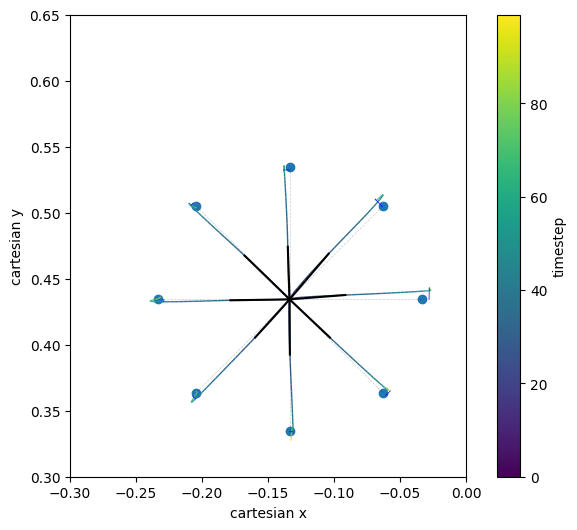

In [43]:
#theta = optimize_channel(cfg_file,weight_file)
K =  175
B = 3

phase = 'NF1'

weight_file = list(Path(data_dir).glob(f'{model_name}_phase={phase}_*_weights'))[0]
cfg_file = list(Path(data_dir).glob(f'{model_name}_phase={phase}_*_cfg.json'))[0]

data = test(cfg_file,weight_file,is_channel=True,K=K,B=B)
fig, ax  = plot.plot_simulations(xy=data['xy'],target_xy=data['tg'], vel=data['vel'],figsize=(8,6))

phase = 'FF1'

weight_file = list(Path(data_dir).glob(f'{model_name}_phase={phase}_*_weights'))[0]
cfg_file = list(Path(data_dir).glob(f'{model_name}_phase={phase}_*_cfg.json'))[0]

data = test(cfg_file,weight_file,is_channel=True,K=K,B=B)
fig, ax  = plot.plot_simulations(xy=data['xy'],target_xy=data['tg'], vel=data['vel'],figsize=(8,6))

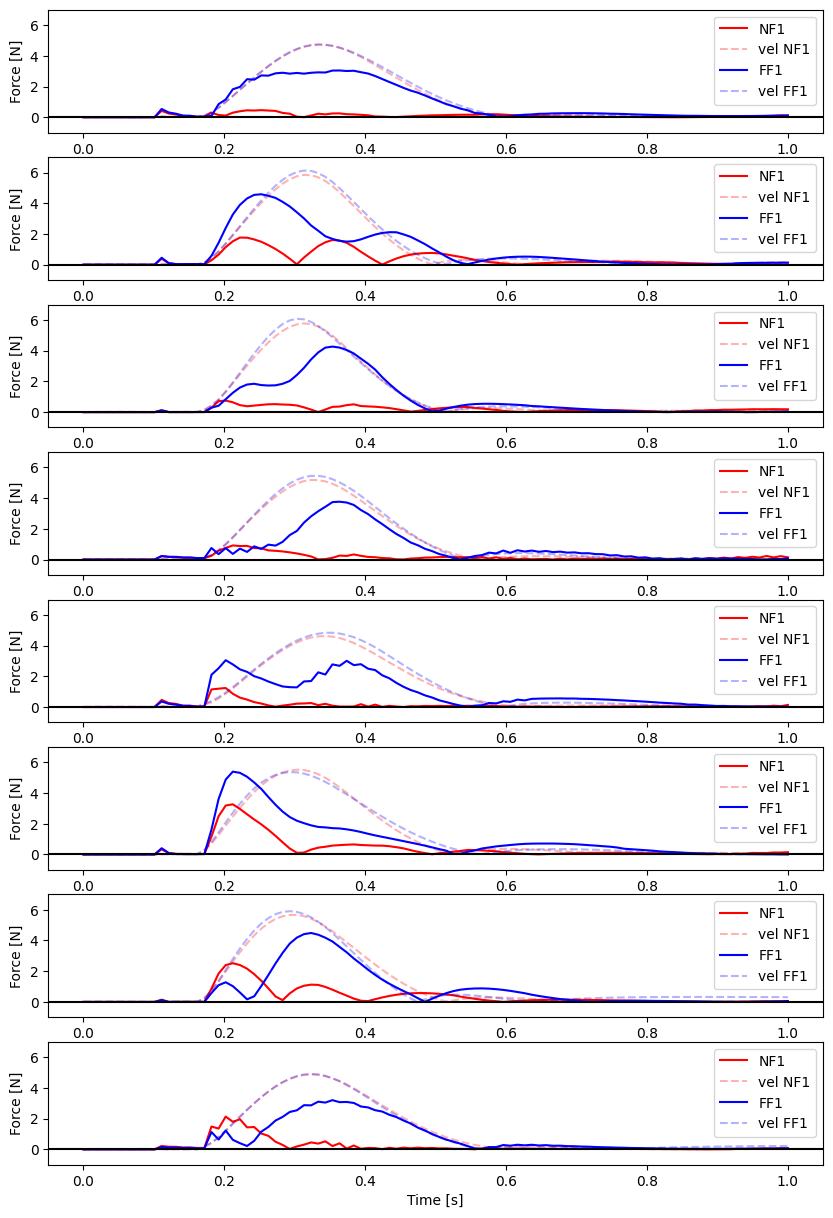

In [44]:
data=[]
label = ['NF1','FF1']
for p in label:
    weight_file = list(Path(data_dir).glob(f'{model_name}_phase={p}_*_weights'))[0]
    cfg_file = list(Path(data_dir).glob(f'{model_name}_phase={p}_*_cfg.json'))[0]
    data.append(test(cfg_file,weight_file,is_channel=True,K=170,B=-1))

fig, ax = plot.plot_force(data,label)